## Airline Passenger Traffic Forecasting 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

### Load Data

In [3]:
data = pd.read_csv('AirPassengers.csv')
data['Month']=pd.to_datetime(data['Month'],infer_datetime_format=True)
data.set_index('Month', inplace=True)
data.head()

/var/folders/rr/zdrb_3hs0dn324twjqgskcmw0000gn/T/ipykernel_58658/2260902753.py:2: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data['Month']=pd.to_datetime(data['Month'],infer_datetime_format=True)


,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


### Data Analysis

In [4]:
ts = data['#Passengers']

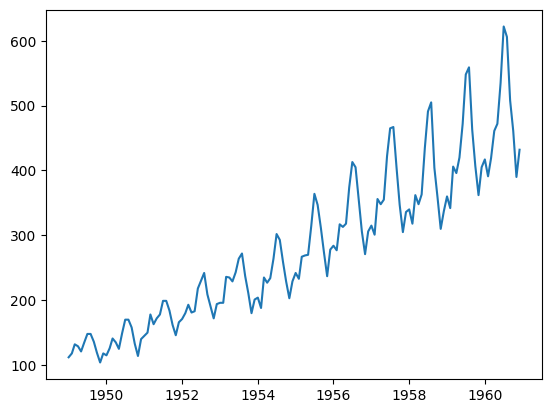

In [5]:
plt.plot(ts)

In [10]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(movingAverage, color='red', label='Rolling Mean')
    plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    airpass_test = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(airpass_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in airpass_test[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

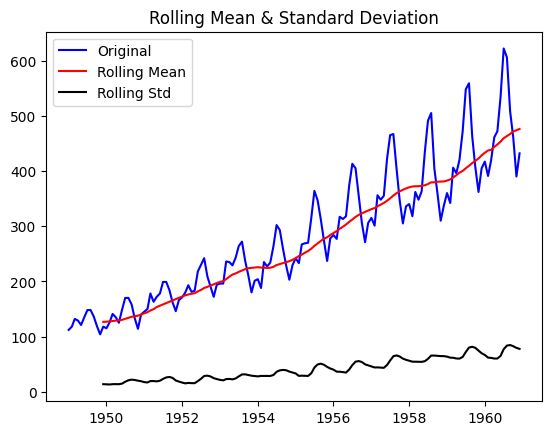

Results of Dickey Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [11]:
test_stationarity(ts)

#### Data Transformation To Achieve Stationarity

##### 1.log transformation
##### 2. subtracting simple moving average
##### 3. subtracting previous value = shift
##### 4. seasonal decomposition

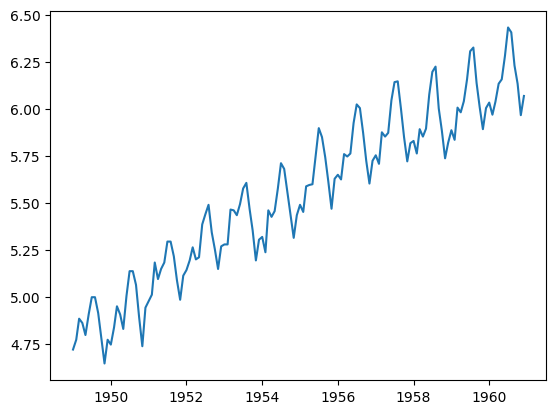

In [12]:
ts_log = np.log(ts)
plt.plot(ts_log)

/var/folders/rr/zdrb_3hs0dn324twjqgskcmw0000gn/T/ipykernel_58658/1853702707.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


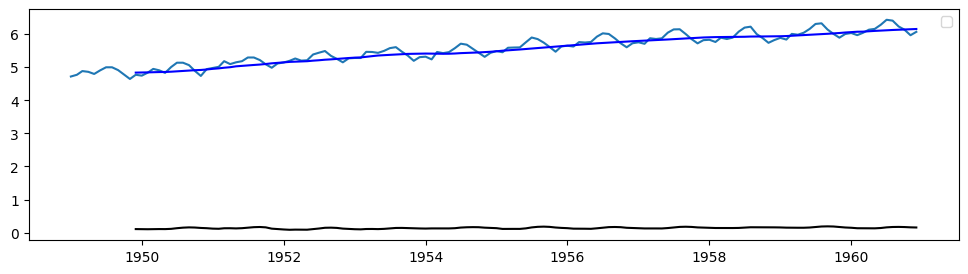

In [14]:
plt.figure(figsize=(12,3))
MAvg=ts_log.rolling(window=12).mean()
MStd=ts_log.rolling(window=12).std()
plt.plot(ts_log)
plt.plot(MAvg, color='blue')
plt.plot(MStd, color='black')
plt.legend()
plt.show()

In [17]:
ts_log_moving_avg_diff=ts_log-MAvg
ts_log_moving_avg_diff=ts_log_moving_avg_diff.dropna()
ts_log_moving_avg_diff.head()

Month
1949-12-01   -0.065494
1950-01-01   -0.093449
1950-02-01   -0.007566
1950-03-01    0.099416
1950-04-01    0.052142
Name: #Passengers, dtype: float64

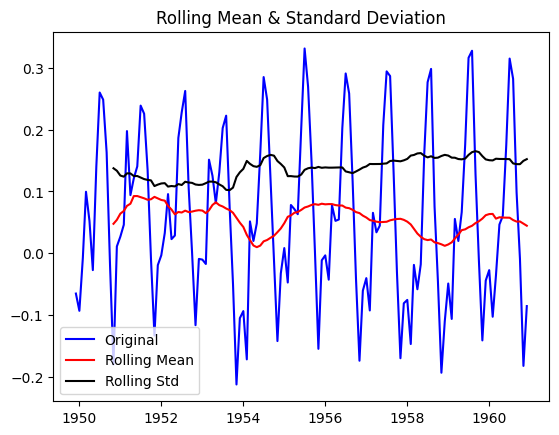

Results of Dickey Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [18]:
test_stationarity(ts_log_moving_avg_diff)


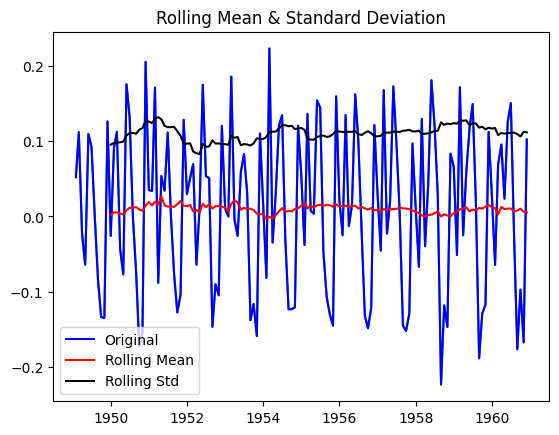

Results of Dickey Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [48]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

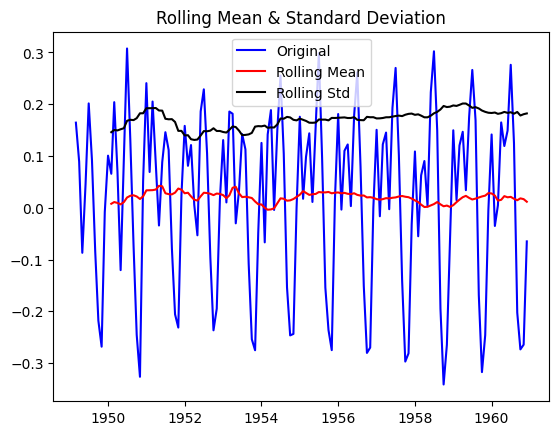

Results of Dickey Fuller Test:
Test Statistic                  -3.167907
p-value                          0.021919
#Lags Used                      11.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [27]:
ts_log_diff2 = ts_log - ts_log.shift(2)
# plt.plot(ts_log_diff2)
ts_log_diff2.dropna(inplace=True)
test_stationarity(ts_log_diff2)

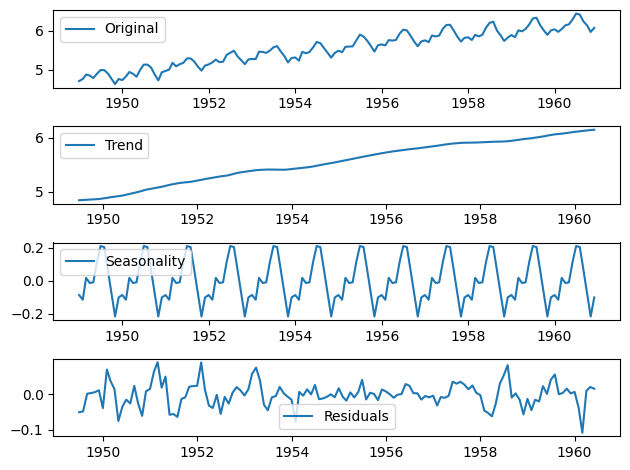

In [28]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

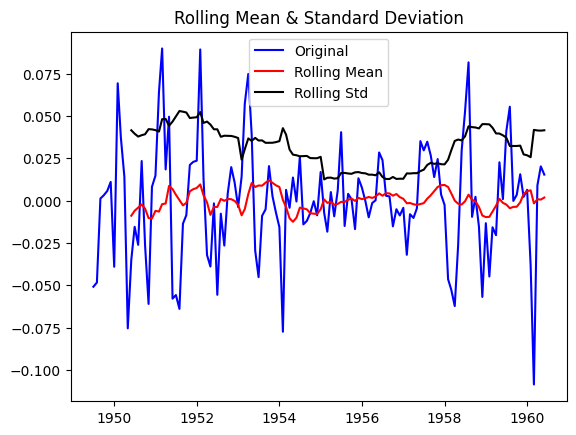

Results of Dickey Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


In [29]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

### Forecasting

#### ACF & PACF Plots

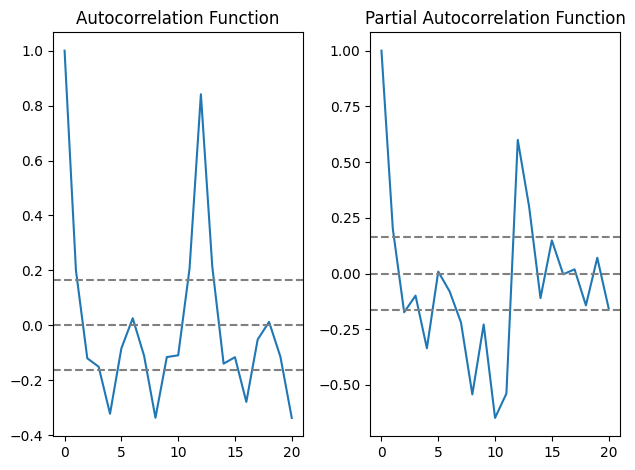

In [49]:
from statsmodels.tsa.stattools import acf, pacf  

lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

#Plot ACF:    
plt.subplot(121)    
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [32]:
p,q = 2,2

In [34]:
from statsmodels.tsa.arima.model import ARIMA

#### AR Model:

/Users/neethu/Desktop/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/neethu/Desktop/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/neethu/Desktop/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


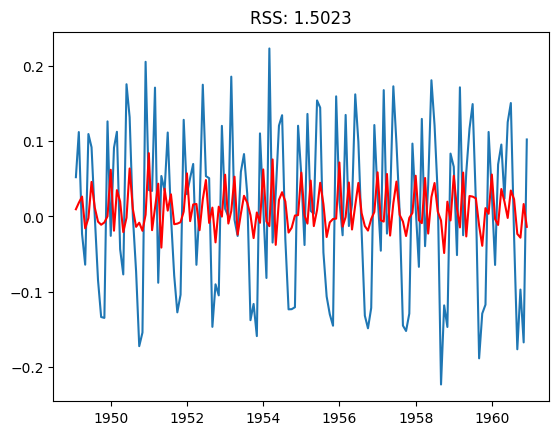

In [52]:
model = ARIMA(ts_log_diff, order=(2, 0, 0)) # d=0 because ts_log_diff is already differenced
results_AR = model.fit()

plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% np.sum((results_AR.fittedvalues - ts_log_diff)**2))
plt.show()

#### MA Model

/Users/neethu/Desktop/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/neethu/Desktop/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/neethu/Desktop/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


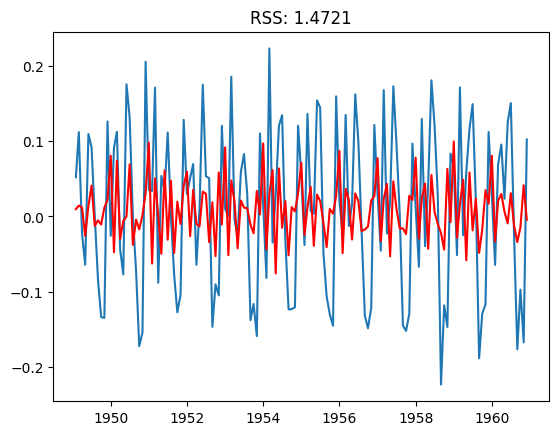

In [62]:
model = ARIMA(ts_log_diff, order=(0, 0, 2)) # d=0 because ts_log_diff is already differenced
results_MA = model.fit()

plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% np.sum((results_MA.fittedvalues - ts_log_diff)**2))
plt.show()

#### ARIMA Model

/Users/neethu/Desktop/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/neethu/Desktop/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/neethu/Desktop/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/neethu/Desktop/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


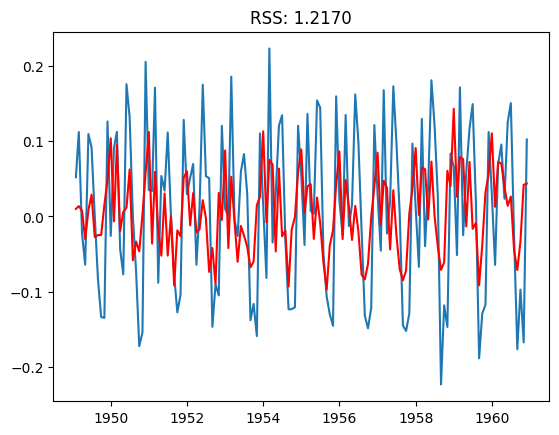

In [84]:
model = ARIMA(ts_log_diff, order=(2, 0, 2)) # d=0 because ts_log_diff is already differenced
results_ARIMA = model.fit()

plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% np.sum((results_ARIMA.fittedvalues - ts_log_diff)**2))
plt.show()

##### Convert ARIMA predictions to original scale:

RSS on Differenced Scale (model optimized): 1.2170
RMSE: 28.5168


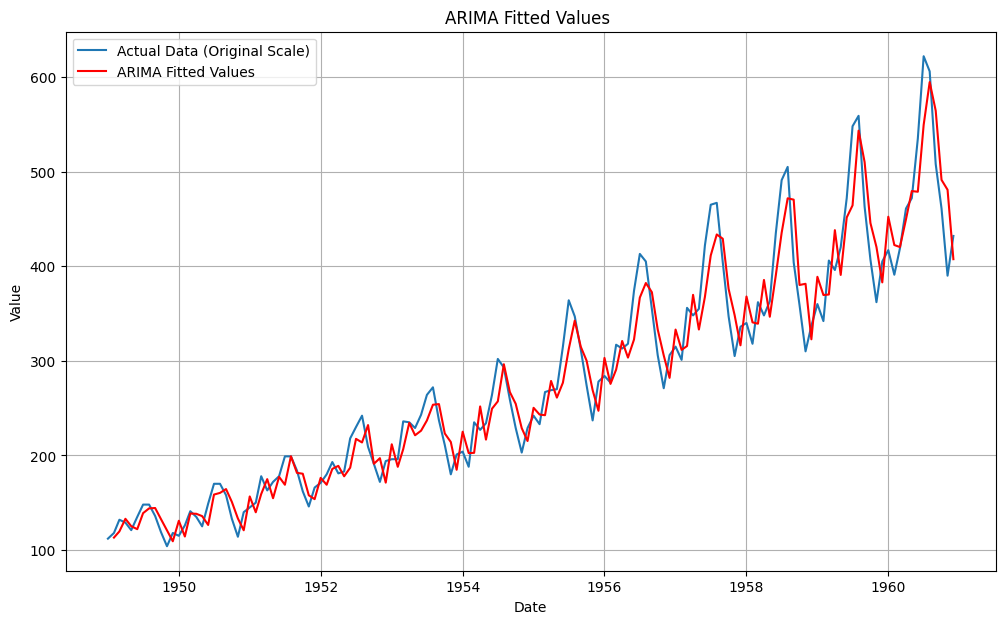

In [176]:
predicted_ts_log_diff = results_ARIMA.fittedvalues
previous_ts_log = ts_log.shift(1).loc[predicted_ts_log_diff.index]

# Sum the predicted differences with the actual previous log values
predicted_ts_log_original_scale = predicted_ts_log_diff + previous_ts_log
predicted_ts = np.exp(predicted_ts_log_original_scale)

# The RSS on the differenced scale (what the model optimized)
rss_differenced_scale = np.sum((results_ARIMA.fittedvalues - ts_log_diff)**2)
print(f"RSS on Differenced Scale (model optimized): {rss_differenced_scale:.4f}")

from sklearn.metrics import mean_squared_error
ts_aligned = ts.loc[predicted_ts.index]
rmse = np.sqrt(mean_squared_error(ts_aligned, predicted_ts))
print(f"RMSE: {rmse:.4f}")


plt.figure(figsize=(12, 7))
plt.plot(ts, label='Actual Data (Original Scale)')
plt.plot(predicted_ts, color='red', label='ARIMA Fitted Values')
plt.title('ARIMA Fitted Values ')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()



##### ARIMA Forecast - 10 years

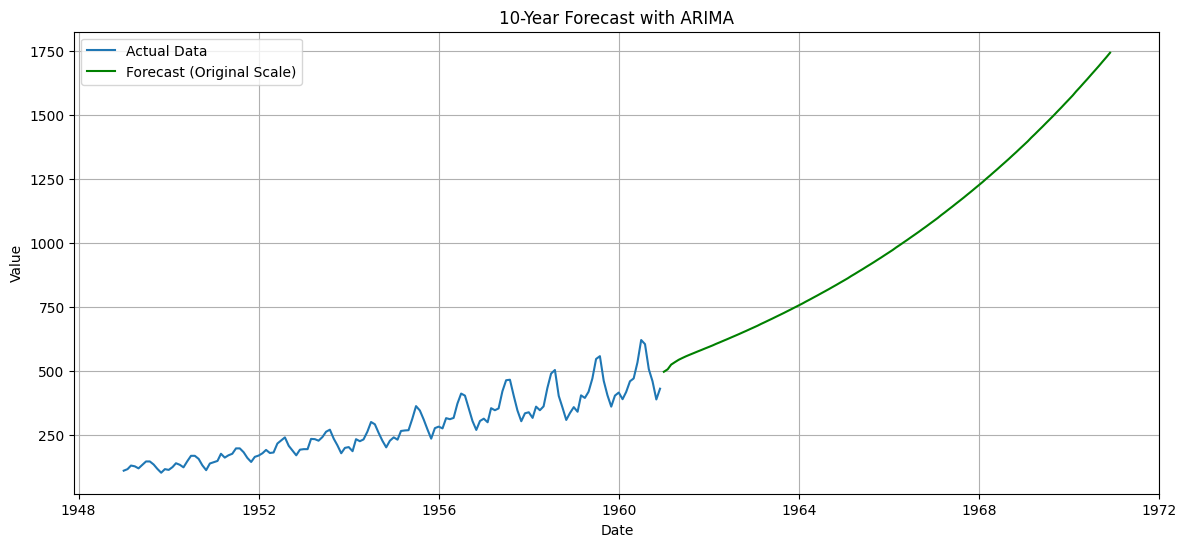

In [140]:
n_steps = 120  # forecast for 10 years = 120 months

forecast_diff = results_ARIMA.get_forecast(steps=n_steps)
forecast_diff_mean = forecast_diff.predicted_mean
last_log = ts_log.iloc[-1]

# Reconstruct forecasted log values
forecast_log = forecast_diff_mean.cumsum() + last_log

forecast_original = np.exp(forecast_log)
# Create future monthly dates starting after last date
forecast_index = pd.date_range(start=ts.index[-1] + pd.DateOffset(months=1), periods=n_steps, freq='MS')
forecast_original.index = forecast_index

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(ts, label='Actual Data')
plt.plot(forecast_original, label='Forecast (Original Scale)', color='green')
plt.title('10-Year Forecast with ARIMA')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


#### SARIMA

In [252]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(ts_log, 
                order=(2, 1, 2), 
                seasonal_order=(1, 1, 1, 12),
                enforce_stationarity=False, 
                enforce_invertibility=False)

results_sarima = model.fit(disp=False)


/Users/neethu/Desktop/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/neethu/Desktop/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/neethu/Desktop/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



SARIMAX In-Sample RMSE (on Original Scale): 108.8321


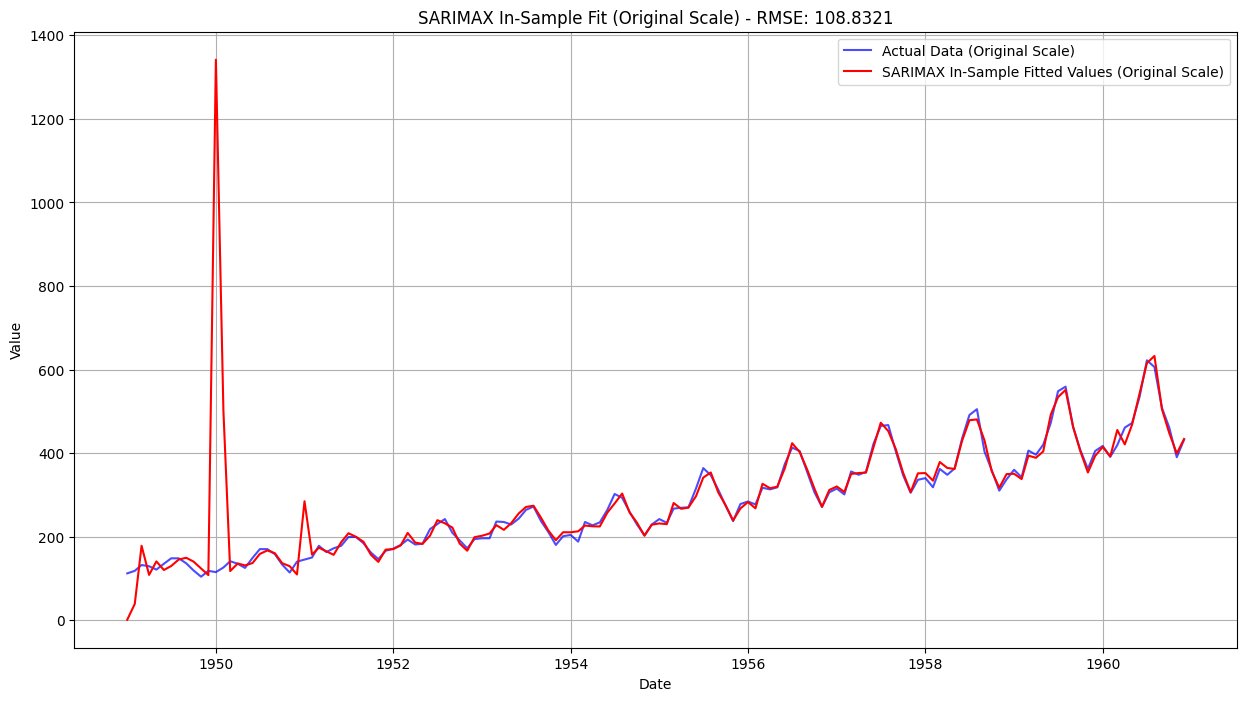

In [259]:
fitted_ts_log = results_sarima.fittedvalues

# --- 2. Reverse Log Transformation to get predictions on original scale ---
predictions_original_scale = np.exp(fitted_ts_log)

# --- 3. Align Actual Data with Fitted Values for comparison ---
# The fitted values will have fewer points than the original 'ts'
# due to the differencing required by the SARIMAX model.
# We need to ensure we compare only the overlapping periods by index.
actual_aligned_ts = ts.loc[predictions_original_scale.index]

# --- 4. Calculate RMSE (Root Mean Squared Error) ---
rmse = np.sqrt(mean_squared_error(actual_aligned_ts, predictions_original_scale))

print(f"\nSARIMAX In-Sample RMSE (on Original Scale): {rmse:.4f}")

# --- 5. Plot Actual vs. Fitted Values on Original Scale ---
plt.figure(figsize=(15, 8))

# Plot actual historical data
plt.plot(ts, label='Actual Data (Original Scale)', color='blue', alpha=0.7)

# Plot the in-sample fitted values on the original scale
plt.plot(predictions_original_scale, label='SARIMAX In-Sample Fitted Values (Original Scale)', color='red', linestyle='-')

plt.title(f'SARIMAX In-Sample Fit (Original Scale) - RMSE: {rmse:.4f}')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


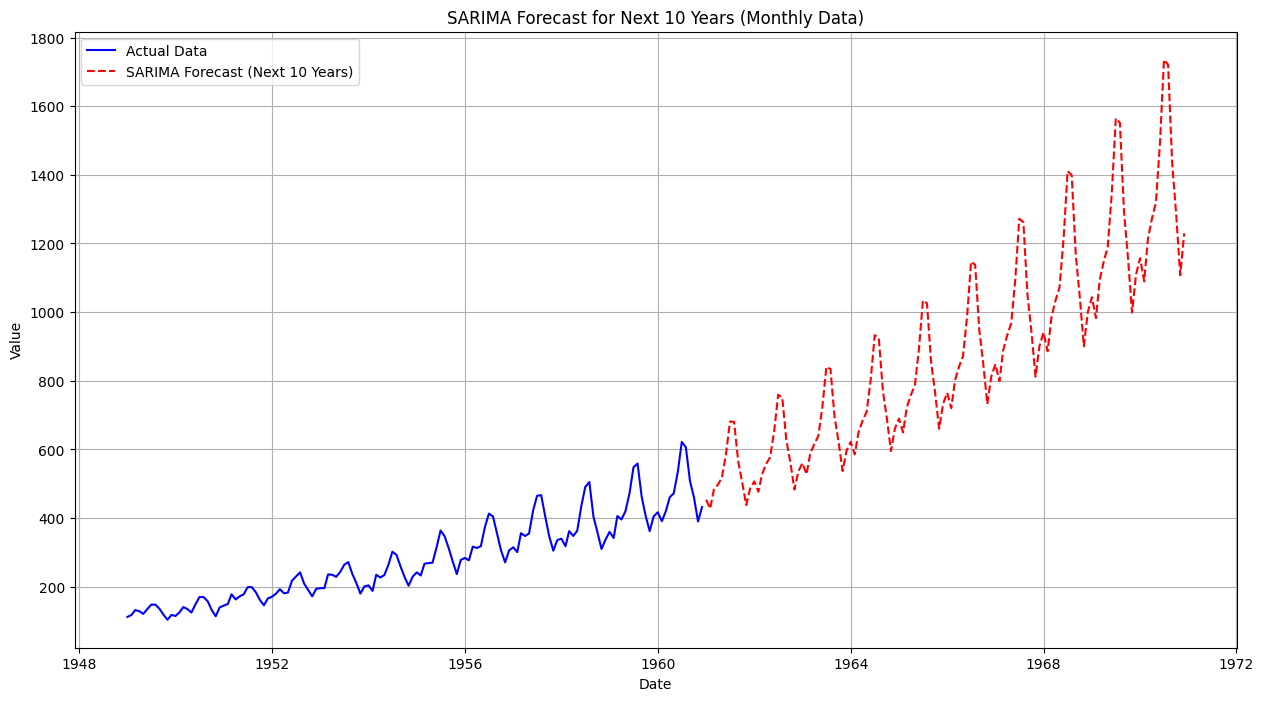


SARIMA Forecasted values (first 5 and last 5 for 10 years):
1961-01-01    453.492375
1961-02-01    427.689497
1961-03-01    483.024922
1961-04-01    497.661738
1961-05-01    518.628877
Freq: MS, Name: predicted_mean, dtype: float64
...
1970-08-01    1720.928007
1970-09-01    1434.315720
1970-10-01    1286.197801
1970-11-01    1107.637355
1970-12-01    1229.852629
Freq: MS, Name: predicted_mean, dtype: float64


In [261]:
# --- Generate the Forecast ---
forecast_years = 10
steps_to_forecast = forecast_years * 12 # 12 months per year (monthly data)

# .get_forecast() will return predictions on the ts_log scale
forecast_results_sarima = results_sarima.get_forecast(steps=steps_to_forecast)

# Extract only the mean forecast on the ts_log scale
forecast_ts_log_mean = forecast_results_sarima.predicted_mean

# --- Reverse Log Transformation ---
# Exponentiate to get forecasts back to the original data scale
forecast_original_scale = np.exp(forecast_ts_log_mean)

# --- Plotting the Forecast ---
plt.figure(figsize=(15, 8))

# Plot actual historical data
plt.plot(ts, label='Actual Data', color='blue')

# Plot the forecasted mean
plt.plot(forecast_original_scale, label=f'SARIMA Forecast (Next {forecast_years} Years)', color='red', linestyle='--')

plt.title(f'SARIMA Forecast for Next {forecast_years} Years (Monthly Data)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# --- Display Forecasted Values ---
print(f"\nSARIMA Forecasted values (first 5 and last 5 for {forecast_years} years):")
print(forecast_original_scale.head())
print("...")
print(forecast_original_scale.tail())

In [262]:
import joblib

# Export the fitted SARIMA model
joblib.dump(results_sarima, "sarima_model.pkl")

['sarima_model.pkl']